# Hyperparams

In [27]:
interactive_gui = True

# blog post and paper used width=16
width = 8
# width = 16

depth = 2

# the ratio of the number of training datapoints to the number of free
# dimensions in the neural network
# dataset_param_multiple = 10 # still looks like a fractal, but a boring one
# dataset_param_multiple = 0.5
dataset_param_multiple = 1.
# dataset_param_multiple = 'single_datapoint'

minibatch_size = None # full batch training
# minibatch_size = 16

# the dimension of the targets for regression (the y variables)
target_dim = 1
# target_dim = width

nonlinearity = 'tanh'
# nonlinearity = 'relu'
# nonlinearity = 'identity'

phase_space = 'lr_vs_lr'
# phase_space = 'paraminit_vs_lr'

readout = 'loss'
# readout = 'probe_point'

# blog post and paper used opt_steps=500 or opt_steps=1000 for experiments
opt_steps = 100
# opt_steps = 500
# opt_steps = 1000

# the default resolution to use when generating loss landscape visualizations.
# for final products, this should be much larger! e.g. 4096.
default_resolution = 512
# default_resolution = 4096

# figure size, and dpi to use when saving figures.
# (this is mostly overwritten for specific use cases, e.g. saving video. check
# the load_and_generate(...) function)
dpi = 100
figsize = (8,8)
# figsize = (4.5,4.5)

In [28]:
def canonical_name():
  """
  turn hyperparameters in the previous cell into a canonical base filename to
  use for this experimental condition
  """
  return f'zoom_sequence_width-{width}_depth-{depth}_datasetparamratio-{dataset_param_multiple}_minibatch-{minibatch_size}_nonlinearity-{nonlinearity}_phasespace-{phase_space}{"_readout-probe_point" if readout == "probe_point" else ""}'

# Init

In [29]:
image_history = []

In [30]:
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib import cm

from scipy import ndimage

import time
from google.colab import files

import datetime

import pickle

import shutil

In [31]:
# so that results can be saved directly to Google Drive, rather than being lost when the colab kernel stops
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
## tool for computing fractal dimension
!pip install git+https://github.com/PMEAL/porespy.git
import porespy as ps

  Cloning https://github.com/PMEAL/porespy.git to /tmp/pip-req-build-r_oahaay
  Running command git clone --filter=blob:none --quiet https://github.com/PMEAL/porespy.git /tmp/pip-req-build-r_oahaay
  Resolved https://github.com/PMEAL/porespy.git to commit 4575822d007e48219aa7d0a27c1f3eed540361ef
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [33]:
if interactive_gui:
  ## interactive plotting
  !pip install ipympl
  from google.colab import output
  output.enable_custom_widget_manager()
  %matplotlib ipympl
else:
  matplotlib.use('Agg')

# Network and training

In [34]:
def net(theta, X):
  # mean field parameterization
  for W in theta:
    Z = jnp.dot(X, W)/jnp.sqrt(W.shape[0])
    if nonlinearity == 'tanh':
      X = jax.nn.tanh(Z*jnp.sqrt(2))
    elif nonlinearity == 'relu':
      X = jax.nn.relu(Z)*jnp.sqrt(2)
    elif nonlinearity == 'identity':
      X = Z
    else:
      assert False
  return Z /jnp.sqrt(W.shape[0])

def init(rng, width, depth):
  rng = jax.random.split(rng, depth)
  theta = []
  out_width = width
  for i in range(depth):
    if i == depth-1:
      out_width = target_dim
    W = jax.random.normal(rng[i], (width, out_width))
    theta.append(W)
  return theta

def loss(theta, X, Y):
  Z = net(theta, X)
  return jnp.mean((Z - Y)**2)

def hparams_f(hparams, theta):
  """
  convert hyperparameters into a learning rate for each layer in the network
  """
  lr = []
  for i, t in enumerate(theta):
    lr.append(hparams[i%len(hparams)])
  return lr

def train_step(rng, theta, hparams, X, Y):
  if phase_space == 'lr_vs_lr':
    learning_rates = hparams_f(hparams, theta)
  elif phase_space == 'paraminit_vs_lr':
    new_theta = []
    for i, t in enumerate(theta):
      if i == 0:
        t += hparams[0]
      new_theta += [t]
    theta = new_theta
    learning_rates = hparams_f([hparams[1]], theta)
  else:
    assert False, f'invalid phase space {phase_space}'

  if minibatch_size is None:
    _loss, _grad = jax.value_and_grad(loss)(theta, X, Y)
  else:
    idx = jax.random.randint(rng, (minibatch_size,), 0, X.shape[0])
    _X = X[idx]
    _Y = Y[idx]
    # evaluate loss on full batch for smooth visualization
    _loss = loss(theta, X, Y)
    _grad = jax.grad(loss)(theta, _X, _Y)

  if readout == 'probe_point':
    srng = jax.random.PRNGKey(-1234567)
    X_probe = jax.random.normal(srng, (1, X.shape[1]))
    tracked_value = net(theta, X_probe).ravel()[0]
  elif readout == 'loss':
    tracked_value = _loss

  return jax.tree_map(lambda t, g, lr: t - lr*g, theta, _grad, learning_rates), tracked_value

train_step_lrvmap = jax.jit(
    jax.vmap(train_step, in_axes=(None, 0, 0, None, None), out_axes=(0,0)),
    donate_argnums=(0,1))

def train(theta, hparams, X, Y, num_steps, outer_batch_size=50000):

  bs = hparams.shape[0]

  if bs > outer_batch_size:
    # split up the hyperparameter search grid if we would run out of memory
    return jnp.concatenate(
        (train(theta, hparams[:bs//2], X, Y, num_steps),
        train(theta, hparams[bs//2:], X, Y, num_steps)),
        axis=0)

  rng = jax.random.PRNGKey(42)
  rng = jax.random.split(rng, num_steps)
  losses = []
  _theta = jax.tree_map(lambda u: jnp.tile(u, (bs,) + (1,)*len(u.shape)), theta)
  for _rng in rng:
    _theta, _loss = train_step_lrvmap(_rng, _theta, hparams, X, Y)
    losses.append(_loss)

  return convergence_measure_vmap(jnp.stack(losses, axis=-1))

# Analysis and plotting

## Train networks over grid of hyperparameter values and generate image

In [35]:
# @jax.jit
def convergence_measure(v, max_val = 1e6):
  """
  turn the training trajectory into a single number which looks pretty in an
  image
  """

  fin = jnp.isfinite(v)
  v = v*fin + max_val*(1-fin)

  if readout == 'probe_point':
    # return the final value of the function, at the end of training
    return v[-1]

  assert readout == 'loss', 'invalid readout type'

  v /= v[0]
  exceeds = (v > max_val)
  v = v*(1-exceeds) + max_val*exceeds

  converged = (jnp.mean(v[-20:]) < 1) # average over any oscillatory behavior
  return jnp.where(converged, -jnp.sum(v), jnp.sum(1/v))

convergence_measure_vmap = jax.jit(jax.vmap(convergence_measure, in_axes=(0,), out_axes=0))

In [36]:
def gen_img(mnmx, resolution=None):
  """
  generate an image of the hyperparameter landscape,
  for a range of hyperparameter values specified by mnmx
  """

  if resolution is None:
    resolution = default_resolution

  mn1, mx1, mn2, mx2 = mnmx
  rng = jax.random.PRNGKey(0)
  rng, srng = jax.random.split(rng)
  theta = init(srng, width, depth)

  n_params = jnp.sum(jnp.array(jax.tree_map(lambda u: u.size, theta)))

  rng, srng = jax.random.split(rng)

  if dataset_param_multiple == 'single_datapoint':
    batch_size = 1
  else:
    if nonlinearity == 'identity':
      batch_size = int(width*dataset_param_multiple)
    else:
      batch_size = int(n_params*dataset_param_multiple/target_dim)

  X = jax.random.normal(srng, (batch_size, width))
  rng, srng = jax.random.split(rng)
  Y = jax.random.normal(srng, (batch_size, target_dim))

  gg1 = jnp.logspace(mn1, mx1, resolution)
  gg2 = jnp.logspace(mn2, mx2, resolution)
  lr0, lr1 = jnp.meshgrid(gg2, gg1)
  lr = jnp.stack([lr0.ravel(), lr1.ravel()], axis=-1)

  V = train(theta, lr, X, Y, opt_steps)

  return V.reshape((resolution, resolution))

## Fractal dimension

In [37]:
def extract_edges(X):
  """
  define edges as sign changes in the scalar representing convergence or
  divergence rate -- on one side of the edge training converges,
  while on the other side of the edge training diverges
  """

  Y = jnp.stack((X[1:,1:], X[:-1,1:], X[1:,:-1], X[:-1,:-1]), axis=-1)
  Z = jnp.sign(jnp.max(Y, axis=-1)*jnp.min(Y, axis=-1))
  return Z<0

def estimate_fractal_dimension(hist_video, show_plot=True):
  edges = [extract_edges(U[0]) for U in hist_video]
  box_counts = [ps.metrics.boxcount(U) for U in edges]
  all_images = np.concatenate([bc.slope for bc in box_counts])

  if show_plot:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_xlabel('box edge length')
    ax1.set_ylabel('number of boxes spanning phases')
    ax2.set_xlabel('box edge length')
    ax2.set_ylabel('image')
    ax2.set_xscale('log')

    for bc in box_counts:
      ax1.plot(bc.size, bc.count,'-o')
      ax2.plot(bc.size, bc.slope,'-o');

  mfd = np.median(all_images)
  print(f'median fractal dimension estimate {mfd}')

  return mfd

## Image restretch to use full color palette

In [38]:
def cdf_img(x, x_ref, buffer=0.25):
  """
  rescale x, relative to x_ref (x_ref is often the same as x), to achieve a uniform
  distribution over values with positive and negative intensities, but also to
  preserve the sign of x. This makes for a visualization that shows more
  structure.
  """

  u = jnp.sort(x_ref.ravel())

  if readout == 'probe_point':
    v = jnp.linspace(-1, 1, u.shape[0])
  elif readout == 'loss':
    num_neg = jnp.sum(u<0)
    num_nonneg = u.shape[0] - num_neg
    v = jnp.concatenate((jnp.linspace(-1,-buffer,num_neg), jnp.linspace(buffer,1,num_nonneg)), axis=0)
  else:
    assert False, 'invalid readout'

  y = jnp.interp(x, u, v)
  return -y

## Code for (interactive) figure display

In [39]:
def truncate_sci_notation(numbers):
  """
  keeping enough significant digits that the
  numbers disagree in four digits
  """

  # Convert numbers to scientific notation
  n1_sci, n2_sci = "{:.15e}".format(numbers[0]), "{:.15e}".format(numbers[1])

  # Extract the significant parts and exponents
  sig_n1, exp_n1 = n1_sci.split('e')
  sig_n2, exp_n2 = n2_sci.split('e')

  # Find the first position at which they disagree
  min_len = min(len(sig_n1), len(sig_n2))
  truncate_index = min_len

  for i in range(min_len):
      if (sig_n1[i] != sig_n2[i]) or (exp_n1 != exp_n2):
          # +4 accounts for 4 digits after the first disagreement
          truncate_index = i + 4
          if i == 0:
            truncate_index += 1 # Account for decimal point
          break

  exp_n1 = exp_n1[0] + exp_n1[2]
  exp_n2 = exp_n2[0] + exp_n2[2]
  if (exp_n1 == "+00") and (exp_n2 == "+00"):
    # don't bother with scientific notation if exponent is 0
    return [sig_n1[:truncate_index], sig_n2[:truncate_index]]

  # Truncate and reconstruct the scientific notation
  truncated_n1 = "{}e{}".format(sig_n1[:truncate_index], exp_n1)
  truncated_n2 = "{}e{}".format(sig_n2[:truncate_index], exp_n2)

  return [truncated_n1, truncated_n2]

def tickslabels(mnmx):
  return mnmx, truncate_sci_notation(10.**np.array(mnmx))


In [40]:
cids = []
click_event = [None]

def onclick(event):
  click_event[0] = (event.xdata, event.ydata)

def onrelease(event, fig, im, rect, mnmx, img, recalculate_image=True):
  if click_event[0] is None:
    return

  e0 = [click_event[0][0], event.xdata]
  e1 = [click_event[0][1], event.ydata]

  for v in e0+e1:
    if v is None:
      return

  newmnmx = [np.min(e1), np.max(e1), np.min(e0), np.max(e0)]

  min_w = (mnmx[1] - mnmx[0])/20
  if newmnmx[1] - newmnmx[0] < min_w:
    c = (newmnmx[1] + newmnmx[0])/2.
    newmnmx[0] = c - min_w/2
    newmnmx[1] = c + min_w/2
  min_w = (mnmx[3] - mnmx[2])/20
  if newmnmx[1] - newmnmx[0] < min_w:
    c = (newmnmx[3] + newmnmx[2])/2.
    newmnmx[2] = c - min_w/2
    newmnmx[3] = c + min_w/2

  for v in newmnmx:
    if v is None:
      return
  plot_img(img, mnmx, newmnmx, fig=fig, im=im, rect=rect)
  plt.draw()

  if recalculate_image:
    click_event[0] = None
    mnmx = newmnmx
    img = gen_img(mnmx)
    plot_img(img, mnmx, None, fig=fig, im=im, rect=rect)

def plot_img(image, mnmx, newmnmx=None, fig=None, im=None, rect=None,
             handler=True, savename=None,
             reference_scale=None,
             cmap='Spectral',
             title=""
             ):
  mn1, mx1, mn2, mx2 = mnmx

  if reference_scale is None:
    reference_scale = image

  image = cdf_img(image, reference_scale)

  ax1 = None
  if fig is None:
    fig, (ax1) = plt.subplots(figsize=figsize, dpi=dpi)
    im = ax1.imshow(image,
                    extent=[mn2, mx2, mn1, mx1],
                    origin='lower',
                    vmin=-1, vmax=1,
                    cmap=cmap,
                    aspect='auto',
                    interpolation='nearest'
                    )
    if title is None:
      batch_text = "full batch" if minibatch_size is None else "minibatch"
      if dataset_param_multiple == 'single_datapoint':
        batch_text = 'single training point'
      title = f'Trainability dependence on {"per-layer learning rates" if phase_space == "lr_vs_lr" else "parameter initialization and learning rate"}\n1 hidden layer, {nonlinearity}, {batch_text}'
    if not title == "":
      plt.title(title)
    if phase_space == 'lr_vs_lr':
      ax1.set_ylabel('Output layer learning rate')
      ax1.set_xlabel('Input layer learning rate')
    elif phase_space == 'paraminit_vs_lr':
      ax1.set_ylabel('Learning rate')
      ax1.set_xlabel('Input layer weight offset')

    rect = patches.Rectangle((mn2, mn1), mx2-mn2, mx1-mn1, linewidth=1, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)

  im.set_extent([mn2, mx2, mn1, mx1])
  im.set_data(image)

  # Set the new tick positions on the x-axis
  aaxx = plt.gca()
  aaxx.set_xticks(*tickslabels([mn2, mx2]))
  aaxx.set_yticks(*tickslabels([mn1, mx1]), rotation=90)

  labels = aaxx.get_xticklabels()
  labels[0].set_horizontalalignment('left')
  labels[1].set_horizontalalignment('right')
  labels = aaxx.get_yticklabels()
  labels[0].set_verticalalignment('bottom')
  labels[1].set_verticalalignment('top')

  if handler and (newmnmx is None):
    image_history.append((image, mnmx))

  if newmnmx:
    mn1, mx1, mn2, mx2 = newmnmx
  rect.set_xy((mn2, mn1))
  rect.set_width(mx2-mn2)
  rect.set_height(mx1-mn1)

  if handler:
    while len(cids) > 0:
      fig.canvas.mpl_disconnect(cids.pop())

    def onrelease_partial(event):
      return onrelease(event, fig, im, rect, mnmx, img)
    def onmotion_partial(event):
      return onrelease(event, fig, im, rect, mnmx, img, recalculate_image=False)

    cids.append(fig.canvas.mpl_connect('button_press_event', onclick))
    cids.append(fig.canvas.mpl_connect('button_release_event', onrelease_partial))
    # cids.append(fig.canvas.mpl_connect('motion_notify_event', onmotion_partial))

  plt.tight_layout()

  plt.draw()

  if savename:
    plt.savefig(savename)

  return fig, ax1, im


## Animate fractal zoom sequences

In [41]:
def zoom_out_sequence(hist_final, growth_factor=2., max_scale=6):
  """
  generate a sequence of (image, bounds) zooming out from the (image, bounds) in hist_final
  """

  image, mnmx = hist_final

  cT = np.array([(mnmx[0] + mnmx[1])/2., (mnmx[2] + mnmx[3])/2.])
  wT = np.array([mnmx[1] - mnmx[0], mnmx[3] - mnmx[2]])

  hist = [(image, mnmx)]
  w_scale = 1.
  if np.min(wT * w_scale) >= max_scale:
      w_scale *= growth_factor
      new_mnmx = [
          cT[0] - w_scale * wT[0]/2.,
          cT[0] + w_scale * wT[0]/2.,
          cT[1] - w_scale * wT[1]/2.,
          cT[1] + w_scale * wT[1]/2.,
      ]
      hist.insert(0, (np.zeros((2,2)), new_mnmx))


  while np.min(wT * w_scale) < max_scale:
    w_scale *= 2
    mnmx = [
        cT[0] - w_scale * wT[0]/2.,
        cT[0] + w_scale * wT[0]/2.,
        cT[1] - w_scale * wT[1]/2.,
        cT[1] + w_scale * wT[1]/2.,
    ]
    hist.insert(0, (np.zeros((2,2)), mnmx))

  return hist

In [42]:
def interpolate_history(hist1, hist2, alpha):
  """
  get the mnmx (hyperparameter bounding box) value for a fraction alpha between
  two images
  """

  _, mnmx1 = hist1
  _, mnmx2 = hist2

  if alpha == 0:
    # avoid NaNs on very last frame
    return mnmx1

  w1 = np.array([mnmx1[1] - mnmx1[0], mnmx1[3] - mnmx1[2]])
  w2 = np.array([mnmx2[1] - mnmx2[0], mnmx2[3] - mnmx2[2]])
  c1 = np.array([(mnmx1[0] + mnmx1[1])/2, (mnmx1[2] + mnmx1[3])/2])
  c2 = np.array([(mnmx2[0] + mnmx2[1])/2, (mnmx2[2] + mnmx2[3])/2])

  gamma = np.exp((1-alpha)*0 + alpha*np.log(w2/w1))

  # ct = cstar + (c1 - cstar)*gamma
  # c1 = cstar + (c1 - cstar)*1
  # c2 = cstar + (c1 - cstar)*w2/w1
  cstar = (c2 - c1*w2/w1) / (1 - w2 / w1)

  ct = cstar + (c1 - cstar)*gamma
  hwt = gamma*w1

  return [ct[0] - hwt[0]/2, ct[0] + hwt[0]/2, ct[1] - hwt[1]/2, ct[1] + hwt[1]/2]


def em(extent_rev):
  return [extent_rev[2], extent_rev[3], extent_rev[0], extent_rev[1]]

def make_animator(history, timesteps_per_transition=60, reference_scale=None, cmap='Spectral'):

  fig, ax, im1 = plot_img(history[0][0], history[0][1], newmnmx=None,
                          handler=False, reference_scale=reference_scale, cmap=cmap)

  im2 = ax.imshow(
      jnp.zeros_like(history[1][0]), extent=em(history[1][1]), origin='lower',
      vmin = -1, vmax = 1,
      cmap=cmap,
      aspect='auto',
      interpolation='nearest'
      )

  im3 = ax.imshow(
      jnp.zeros_like(history[1][0]), extent=em(history[1][1]), origin='lower',
      vmin = -1, vmax = 1,
      cmap=cmap,
      aspect='auto',
      interpolation='nearest'
      )

  def animate(n):
    hist_index = n // timesteps_per_transition
    alpha = (n % timesteps_per_transition) / timesteps_per_transition

    hist1 = history[hist_index]
    if hist_index >= len(history)-1:
      hist2 = hist1 # very last frame
    else:
      hist2 = history[hist_index+1]
    if hist_index >= len(history)-2:
      hist3 = hist2 # very last frame
    else:
      hist3 = history[hist_index+2]

    lims = interpolate_history(hist1, hist2, alpha)

    # interpolation scheme for image restretch / colormap
    alpha_area = jnp.sin(alpha*np.pi/2)**2

    print(f'frame {n} / {timesteps_per_transition*len(history)}, zoom step {hist_index} / {len(history)}', end='\r', flush=True)

    img_1 = (1-alpha_area)*cdf_img(hist1[0], hist1[0]) + alpha_area*cdf_img(hist1[0], hist2[0])
    img_2 = (1-alpha_area)*cdf_img(hist2[0], hist1[0]) + alpha_area*cdf_img(hist2[0], hist2[0])
    img_3 = (1-alpha_area)*cdf_img(hist3[0], hist1[0]) + alpha_area*cdf_img(hist3[0], hist2[0])

    im1.set_data(img_1)
    im1.set_extent(em(hist1[1]))
    im2.set_data(img_2)
    im2.set_extent(em(hist2[1]))
    im3.set_data(img_3)
    im3.set_extent(em(hist3[1]))
    im3.set_alpha(alpha)

    ax.set_ylim(lims[0], lims[1])
    ax.set_xlim(lims[2], lims[3])

    # Set the new tick positions
    ax.set_xticks(*tickslabels([lims[2], lims[3]]))
    ax.set_yticks(*tickslabels([lims[0], lims[1]]), rotation=90)

    labels = ax.get_xticklabels()
    labels[0].set_horizontalalignment('left')
    labels[1].set_horizontalalignment('right')
    labels = ax.get_yticklabels()
    labels[0].set_verticalalignment('bottom')
    labels[1].set_verticalalignment('top')

    return fig,

  anim = animation.FuncAnimation(fig,animate,frames=timesteps_per_transition*(len(history)-1)+1, repeat=False)
  return anim

# generate images and movies

## ****************** Interactive exploration of fractal landscape! You will spend most of your time in this cell. ******************

Click and drag to zoom in on parts of the image. It may take some time to recompute and update the image. You will not see the selection box while you are dragging,but the new image will be computed after you release the mouse button.

If images look speckled or noisy, increase the `default_resolution` in the init cell (this will  slow down image generation).


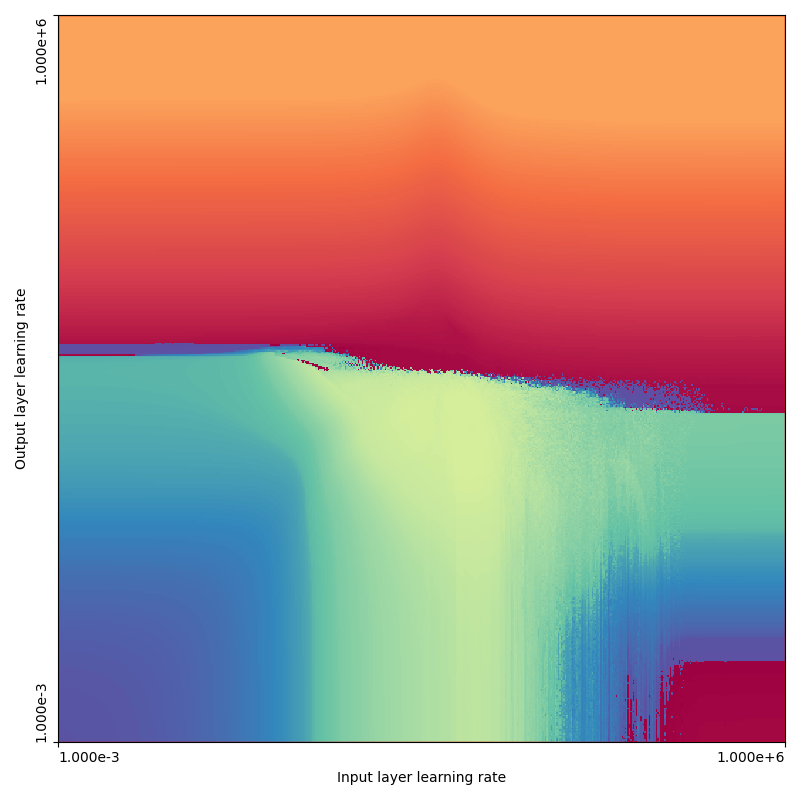

In [43]:
assert interactive_gui, "Set interactive_gui to True in the first cell, and restart the colab kernel"

plt.close('all')
plt.ion()

mnmx = [-3, 6, -3, 6]
img = gen_img(mnmx)
plot_img(img, mnmx, None)
plt.show()

## Show all the generated images

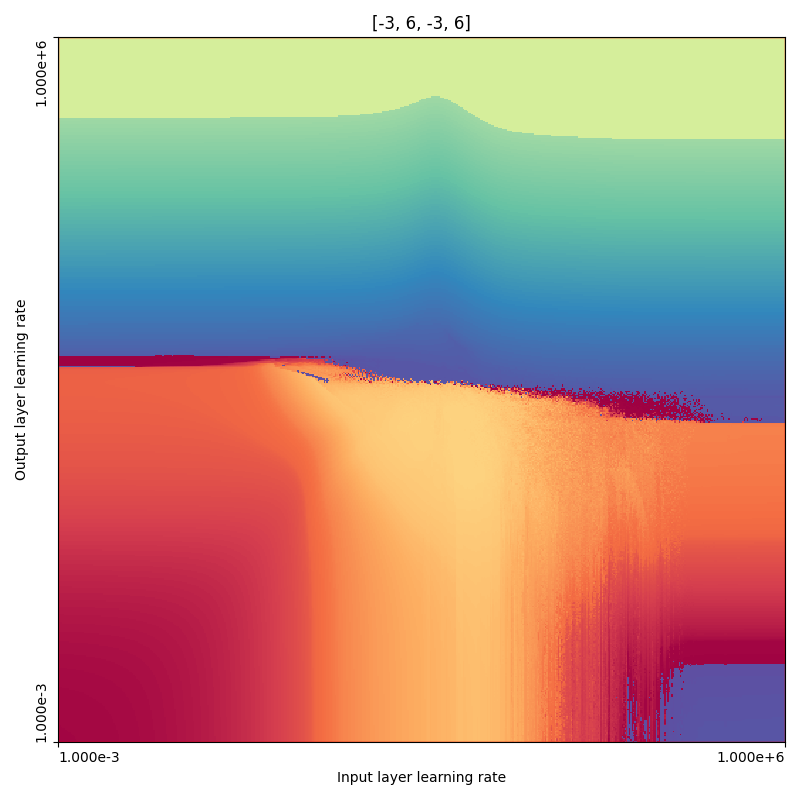

In [44]:
plt.close('all')

for ii, impair in enumerate(image_history):
  image, mnmx = impair
  newmnmx = None
  if ii < len(image_history)-1:
    newmnmx = image_history[ii+1][1]
  # fname = f'fractal_train_width{width}_depth{depth}_datasetparamratio{dataset_param_multiple}_minibatch{minibatch_size}_nonlinearity{nonlinearity}_step{ii}_coords{mnmx}.pdf'
  fname = None
  # print(ii, mnmx)
  plot_img(image, mnmx, newmnmx=newmnmx, handler=False, savename=fname)
  plt.title(mnmx)
  plt.tight_layout()
  # files.download(fname)

## generate a movie, and save the raw keyframes as a pickle file

In [45]:
hist_video = zoom_out_sequence(image_history[-1], growth_factor=2.)

In [46]:
# each call to increase_resolution increases the resolution of one image and
# returns True, or returns False if all images are at or exceed the target resolution
while increase_resolution(hist_video, 2048):
  with open(f'/content/drive/MyDrive/fractal/{canonical_name()}.pickle', 'wb') as handle:
      pickle.dump(hist_video, handle, protocol=pickle.HIGHEST_PROTOCOL)

increasing resolution of 0 / 2 at 2025-07-29 19:16:23.407465, current resolution is (2, 2)
increasing resolution of 1 / 2 at 2025-07-29 19:20:59.374632, current resolution is (512, 512)


In [49]:
ts = 30
anim = make_animator(hist_video, timesteps_per_transition=ts*2)
anim.save(f'/content/drive/MyDrive/fractal/{canonical_name()}.mp4',fps=ts, dpi=dpi)
plt.close('all')

# Generate the high quality images, movies, and fractal dimension estimates used in the blog post and paper

Before running this code, you should copy [this fractal Google Drive folder](https://drive.google.com/drive/folders/1-LKmtV1-kP-VJClHUuPlzRb2WPQMq4mx) into you own Google Drive, so you have access to the same raw data.

## convenience code to generate and save fractal images and movie

In [3]:
def load_and_generate(canonical=None, max_frame=999999):
  global dpi
  global figsize

  dpi = 1000
  figsize = (5.2,4.5)

  assert not interactive_gui, "Set interactive_gui to False in the first cell, and restart the colab kernel"

  if canonical is None:
    canonical = canonical_name()

  print(f'generating images and movie for {canonical}')

  try:
    with open(f'/content/drive/MyDrive/fractal/{canonical}.pickle', 'rb') as handle:
      hist_video = pickle.load(handle)
  except FileNotFoundError:
    # Try with the -010 suffix
    try:
      with open(f'/content/drive/MyDrive/fractal/{canonical}-010.pickle', 'rb') as handle:
        hist_video = pickle.load(handle)
    except FileNotFoundError:
      print("Could not find the data file. Please ensure the 'fractal' folder is correctly set up in your Google Drive.")
      return


  hist_video = hist_video[:max_frame]

  # make sure we are at full resolution
  # each call to increase_resolution increases the resolution of one image and returns True, or returns False if all images are at or exceed the targer resolution
  while increase_resolution(hist_video, 4096):
    with open(f'/content/drive/MyDrive/fractal/{canonical}.pickle', 'wb') as handle:
        pickle.dump(hist_video, handle, protocol=pickle.HIGHEST_PROTOCOL)

  for ii, impair in enumerate(hist_video):
    img, mnmx = impair
    fname = f'/content/drive/MyDrive/fractal/{canonical}_step-{ii}.pdf'
    plot_img(img, mnmx, handler=False, savename=fname, title="")
    plt.close('all')

  estimate_fractal_dimension(hist_video)
  plt.close('all')

  # dpi of 1500 might seem excessive, but we need a very high resolution,
  # otherwise we get ugly transcoding errors when we upload to vimeo or youtube
  dpi = 1500
  figsize = (5.5,5.5)
  ts = 30
  anim = make_animator(hist_video, timesteps_per_transition=int(ts*1.5))
  fname = f'{canonical}.mp4'
  writer=animation.FFMpegWriter(bitrate=200000, codec='hevc', fps=ts)
  anim.save(fname, dpi=dpi, writer=writer)
  shutil.copyfile(fname, f'/content/drive/MyDrive/fractal/{fname}')
  plt.close('all')

## batch size 1

In [4]:
interactive_gui = False
width = 16
depth = 2
dataset_param_multiple = 'single_datapoint'
minibatch_size = None
target_dim = 1
nonlinearity = 'tanh'
phase_space = 'lr_vs_lr'
readout = 'loss'

load_and_generate()

# zoom_sequence_width-16_depth-2_datasetparamratio-single_datapoint_minibatch-None_nonlinearity-tanh_phasespace-lr_vs_lr.pickle

NameError: name 'canonical_name' is not defined

## tanh full batch initialization shift vs learning rate

In [1]:
width = 16
depth = 2
dataset_param_multiple = 1.
minibatch_size = None
target_dim = 1
nonlinearity = 'tanh'
phase_space = 'paraminit_vs_lr'
readout = 'loss'

load_and_generate()

NameError: name 'load_and_generate' is not defined

## linear full batch

In [ ]:
width = 16
depth = 2
dataset_param_multiple = 1.
minibatch_size = None
target_dim = 1
nonlinearity = 'identity'
phase_space = 'lr_vs_lr'
readout = 'loss'

load_and_generate()

## relu full batch

In [ ]:
width = 16
depth = 2
dataset_param_multiple = 1.
minibatch_size = None
target_dim = 1
nonlinearity = 'relu'
phase_space = 'lr_vs_lr'
readout = 'loss'

load_and_generate(max_frame=52)

## tanh full batch


In [ ]:
width = 16
depth = 2
dataset_param_multiple = 1.
minibatch_size = None
target_dim = 1
nonlinearity = 'tanh'
phase_space = 'lr_vs_lr'
readout = 'loss'

load_and_generate(max_frame=49)

## tanh minibatch

In [ ]:
width = 16
depth = 2
dataset_param_multiple = 1.
minibatch_size = 16
target_dim = 1
nonlinearity = 'tanh'
phase_space = 'lr_vs_lr'
readout = 'loss'

load_and_generate()

# turn down the runtime

In [ ]:
import time
import datetime

print("countdown to shutdown ", datetime.datetime.now())

time.sleep(3000)

print("shutting down ", datetime.datetime.now())

from google.colab import runtime
runtime.unassign()

In [ ]:
import os

# Define the path to the fractal data directory
fractal_dir = '/content/drive/MyDrive/fractal/'

# Check if the directory exists
if os.path.exists(fractal_dir):
    print(f"Files in '{fractal_dir}':")
    # List the files in the directory
    files = os.listdir(fractal_dir)
    if files:
        for f in sorted(files):
            print(f)
    else:
        print("The directory is empty.")
else:
    print(f"The directory '{fractal_dir}' does not exist.")
    print("Please make sure you have mounted your Google Drive and copied the fractal data folder as instructed.")

# Get the filename for the current settings
hyperparameters_filename = canonical_name() + ".pickle"
print("\nThe code is currently looking for this file:")
print(hyperparameters_filename)

# Check if the specific file exists
if os.path.exists(os.path.join(fractal_dir, hyperparameters_filename)):
    print("\nGood news! The required file exists.")
else:
    print("\nThe required file is missing from the directory.")

In [ ]:
def increase_resolution(hist_video, target_resolution):
  """
  Check the resolution of each image in hist_video and regenerate it at a
  higher resolution if it is smaller than target_resolution.
  """
  for i, (img, mnmx) in enumerate(hist_video):
    if img.shape[0] < target_resolution:
      print(f"increasing resolution of {i} / {len(hist_video)} at {datetime.datetime.now()}, current resolution is {img.shape}")
      hist_video[i] = (gen_img(mnmx, resolution=target_resolution), mnmx)
      return True
  return False

In [ ]:
def increase_resolution(hist_video, target_resolution):
  """
  Check the resolution of each image in hist_video and regenerate it at a
  higher resolution if it is smaller than target_resolution.
  """
  for i, (img, mnmx) in enumerate(hist_video):
    if img.shape[0] < target_resolution:
      print(f"increasing resolution of {i} / {len(hist_video)} at {datetime.datetime.now()}, current resolution is {img.shape}")
      hist_video[i] = (gen_img(mnmx, resolution=target_resolution), mnmx)
      return True
  return False